In [28]:
import numpy as np
import re
from tqdm import tqdm
import math
from random import randint
from tqdm import tqdm 
import math

vocab = set()
docs = []
 
D = 472 # number of documents
K = 10 # number of topics

# open each file; convert everything to lowercase and strip non-letter symbols; split into words
for fileind in range( 1, D+1 ):
    foo = open( 'files/output%04d.txt' % fileind ).read()    
    tmp = re.sub( '[^a-z ]+', ' ', foo.lower() ).split()
    docs.append( tmp )
 
    for w in tmp:
        vocab.add( w )
 
# vocab now has unique words
# give each word in the vocab a unique id
ind = 0
vhash = {}
vindhash = {}
for i in list(vocab):
    vhash[i] = ind
    vindhash[ind] = i
    ind += 1
 
# size of our vocabulary
V = ind
 
# reprocess each document and re-represent it as a list of word ids

docs_i = []

for d in docs:
    dinds = []
    for w in d:
        dinds.append( vhash[w] )
    docs_i.append( dinds )

In [29]:
qs = None
alphas = None
gammas = None
topics = None
pdtm = None

def init():
    global qs, alphas, gammas, topics, pdtm
    global K, V, D, docs_i

    # Initial topics for the documents
    qs = randomly_assign_topics(docs_i, K)

    # Parameters for Dirichlet Distribution
    alphas = np.ones((K,1))[:,0]
    gammas = np.ones((V,1))[:,0]

    # Assign the topic distributions for each word
    topics = np.random.dirichlet(gammas, K) # (10, 17675)

    # per-document-topic distributions
    pdtm = np.random.dirichlet(alphas, D) # (472, 10)
    
    

In [30]:
def compute_data_likelihood(docs_i, qs, topics):
    
    likelihood = 0
    
    for i, doc in enumerate(docs_i):

        for j, word in enumerate(doc):
            
            # Find what the word is assigned to
            assigned_topic = qs[i][j]
            likelihood += math.log(topics[assigned_topic, word])

    return likelihood

# Initialize my civk matrix
def calculate_civk():
#     global D, V, K
#     global docs_i
#     global qs
    
    civk = np.zeros([D, V, K])
    
    for i, doc in enumerate(docs_i):
        for j, word in enumerate(doc):
            civk[i,word,qs[i][j]] += 1

    return civk

def randomly_assign_topics(docs, k):
    """ Randomly assigns topics between 0 and K-1"""
    result = []
    for i, doc in enumerate(docs):
        this_doc = []
        for word in doc:
            this_doc.append(np.random.randint(0, K))
        result.append(this_doc)
    return result

In [31]:
# Standard Gibbs Sampling

init()
# resample per-document topic mixtures pdtm
civk = calculate_civk()
cik = np.sum(civk, axis=1)
for i, x in enumerate(cik):
    pdtm[i] = np.random.dirichlet(alphas + x)

# resample topics
cvk = np.sum(civk, axis=0)
for i in xrange(10):
    topics[i] = np.random.dirichlet(gammas + cvk[:,i])
    
    

################################################


num_steps = 5
results = np.empty([num_steps])
#init()
likelihoods_keep = []
for iters in tqdm(xrange(0, num_steps)):
    p = compute_data_likelihood(docs_i, qs, topics)
#     if iters % 10 == 0:
#         clear_output()
    print "Iter %d, p=%.2f" % (iters,p)
    results[iters] = p
    likelihoods_keep.append(p)
    
 
    # resample per-word topic assignments qs
    for i, doc in enumerate(qs):
        for j, word in enumerate(doc):
            probs = pdtm[i,:] * topics[:,word]
            probs = probs / np.sum(probs)
            qs[i][j] = np.random.choice(K, p=probs)
            
    # resample per-document topic mixtures pdtm
    civk = calculate_civk()
    cik = np.sum(civk, axis=1) 
#     for i, x in enumerate(cik):
#         pdtm[i] = np.random.dirichlet(alphas + x)
        
    for i in xrange(D):
        pdtm[i] = np.random.dirichlet(alphas + cik[i])
 
    # resample topics
    cvk = np.sum(civk, axis=0)
    for i in xrange(10):
        topics[i] = np.random.dirichlet(gammas + cvk[:,i])

  0%|          | 0/5 [00:00<?, ?it/s]

Iter 0, p=-5368233.59


 20%|██        | 1/5 [00:27<01:50, 27.71s/it]

Iter 1, p=-5368626.76


 40%|████      | 2/5 [00:59<01:26, 28.95s/it]

Iter 2, p=-5368204.12


 60%|██████    | 3/5 [01:26<00:56, 28.20s/it]

Iter 3, p=-5368644.66


 80%|████████  | 4/5 [01:52<00:27, 27.60s/it]

Iter 4, p=-5368672.03


100%|██████████| 5/5 [02:20<00:00, 27.72s/it]


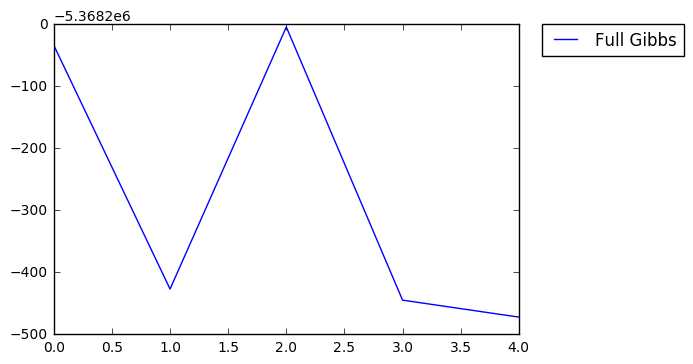

In [32]:
import matplotlib.pyplot as plt

plt.plot(range(5), likelihoods_keep, label='Full Gibbs')
#plt.plot(range(5), collapsed_gibbs_likelihoods, label='Collapsed Gibbs')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [33]:
for i, doc in enumerate(qs):
        for j, word in enumerate(doc):
            probs = pdtm[i,:] * topics[:,word]
            

In [34]:
print pdtm[0,:].shape
print topics[:,0].shape

probs = pdtm[0,:] * topics[:,0]
print probs.shape

(10,)
(10,)
(10,)
